In [1]:
!pip install transformers datasets torch matplotlib

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments, TrainerCallback
from torchvision.transforms import Compose, Resize, ToTensor

C:\Users\john\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class CroppedWordDataset(Dataset):
    def __init__(self, root_dir, processor, split='train', image_size=(224, 224), max_length=128):
        self.root_dir = root_dir
        self.processor = processor
        self.split = split
        self.images_dir = os.path.join(root_dir, split, 'images')
        self.labels_dir = os.path.join(root_dir, split, 'labels')
        self.image_files = sorted(os.listdir(self.images_dir))
        self.label_files = sorted(os.listdir(self.labels_dir))
        self.transform = Compose([Resize(image_size), ToTensor()])
        self.max_length = max_length

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        label_path = os.path.join(self.labels_dir, self.label_files[idx])

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        with open(label_path, 'r', encoding='utf-8') as f:
            text = f.read().strip()

        encoding = self.processor(images=image, text=text, return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_length)
        pixel_values = encoding['pixel_values'].squeeze()
        labels = encoding['labels'].squeeze()
        return {"pixel_values": pixel_values, "labels": labels}


In [4]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-stage1")

# Set decoder start token id
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def collate_fn(batch):
    pixel_values = [item['pixel_values'] for item in batch]
    labels = [item['labels'] for item in batch]
    return {"pixel_values": torch.stack(pixel_values), "labels": torch.stack(labels)}

train_dataset = CroppedWordDataset(root_dir='dataset', processor=processor, split='train')
val_dataset = CroppedWordDataset(root_dir='dataset', processor=processor, split='val')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)


In [6]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    save_steps=10_000,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_dir="./logs",
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
)


C:\Users\john\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Unused or unrecognized kwargs: max_length, padding, truncation.
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.


Epoch,Training Loss,Validation Loss
1,No log,6.079464
2,No log,0.574757
3,No log,0.381606


Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_lengt

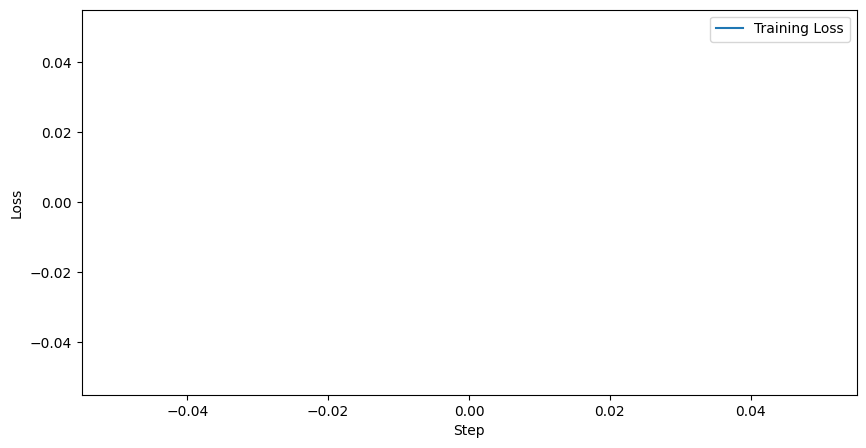

In [7]:
class LossCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.losses.append(logs.get('loss'))

# Initialize callback
loss_callback = LossCallback()

# Update the trainer to include the callback
trainer.add_callback(loss_callback)

# Train the model
trainer.train()

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_callback.losses, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [8]:
results = trainer.evaluate()
print(results)

Unused or unrecognized kwargs: max_length, padding, truncation.
Unused or unrecognized kwargs: max_length, padding, truncation.


{'eval_loss': 0.3816063702106476, 'eval_runtime': 4.1994, 'eval_samples_per_second': 0.476, 'eval_steps_per_second': 0.238, 'epoch': 3.0}


In [11]:
def ocr_inference(image_path, model, processor):
    image = Image.open(image_path).convert("RGB")
    encoding = processor(images=image, return_tensors="pt")
    pixel_values = encoding['pixel_values']

    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

# Example inference
image_path = 'c02-049-01-07.png'
text = ocr_inference(image_path, model, processor)
print("Recognized text:", text)

C:\Users\john\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\generation\utils.py:1259: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Recognized text: Cosmini P.
